# Download data for AOI using bash-API

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

The script uses SentinelHUb's batch API to download all acquisitions over a given time-interval.

The downloaded images are:

 * Sentinel-2 L1C B02, B03, B04, B08 (e.g. bands a t 10m resolution);
 * CLP band;
 * data mask.

The download is executed using SentinelHub batch API, which automatically splits the AOI into a grid and downloads data for each tile in an extremely scalable way, speeding up the process and reducing the processing units.

In [ ]:
%matplotlib inline

import concurrent.futures
import itertools as it
from pathlib import Path

import geopandas as gpd
from tqdm.auto import tqdm

from eolearn.core import get_filesystem

from sentinelhub import (
    CRS,
    BatchSplitter,
    DataCollection,
    MimeType,
    SentinelHubRequest
)

In [2]:
from fd.download import (
    DownloadConfig,
    create_batch_request, 
    monitor_batch_job, 
    plot_batch_splitter,
    get_tile_status_counts
)

## Set up paths and parameters for requests

In [3]:
INPUT_DATA_DIR = Path('../../input-data/')

### Set up configuration file for download

Set up the config file with all info about the batch process API download, including the SH (`sh_client_id` and `sh_client_secret`) and AWS bucket (`aws_access_key_id` and `aws_secret_access_key`) credentials

In [4]:
download_config = DownloadConfig(
    bucket_name='sinergise-niva',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    sh_client_id='',
    sh_client_secret='',
    aoi_filename=str(INPUT_DATA_DIR/'cyl-province-border.geojson'),
    time_interval=('2020-03-15', '2020-05-15'),
    data_collection=DataCollection.SENTINEL2_L1C,
    grid_definition=dict(grid_id=1, resolution=10, buffer=(50, 50)),
    tiles_path='data/Castilla/2020-04/tiffs',
    maxcc=0.7
)

## Batch request 

In [5]:
output_responses = [SentinelHubRequest.output_response(band, MimeType.TIFF) 
                   for band in ['B02', 'B03', 'B04', 'B08', 'dataMask', 'CLP']] + \
                    [SentinelHubRequest.output_response('userdata', MimeType.JSON)]

In [6]:
batch_data = create_batch_request(config=download_config,
                                  output_responses=output_responses,
                                  description='CyL batch request - April 2020')

In [7]:
batch_data

SentinelHubBatch({
  id: ...
  description: CyL batch request - April 2020
  created: 2020-12-21T22:28:38.824Z
  status: CREATED
  userAction: NONE
  tileCount: 1033
  ...
})

### Analyse batch request

In [8]:
batch_data.start_analysis()

''

In [14]:
batch_data.update_info()
batch_data

SentinelHubBatch({
  id: ...
  description: CyL batch request - April 2020
  created: 2020-12-21T22:28:38.824Z
  status: ANALYSIS_DONE
  userAction: ANALYSE
  valueEstimate: 140005.7441392164
  tileCount: 1083
  ...
})

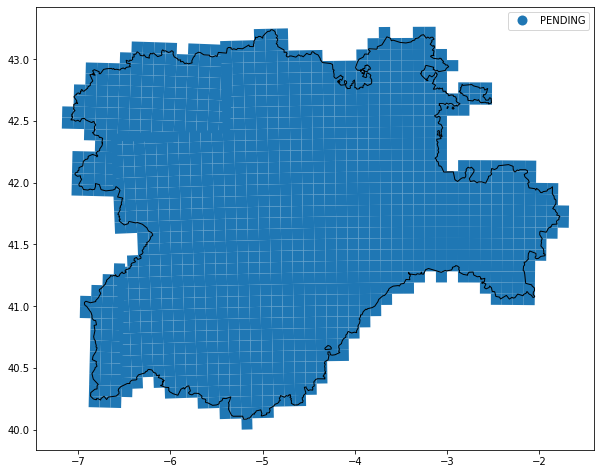

In [15]:
splitter = BatchSplitter(batch_request=batch_data)
plot_batch_splitter(splitter)

Store grid definition in geodataframe

In [16]:
grid_gdf = gpd.GeoDataFrame({
    'id': [info['id'] for info in splitter.get_info_list()],
    'name': [info['name'] for info in splitter.get_info_list()],
    'geometry': splitter.get_bbox_list()
}, crs=splitter.crs.pyproj_crs())

In [17]:
grid_gdf.head()

,id,name,geometry
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795..."
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148..."
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146..."
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318..."
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315..."


### Run batch request

In [18]:
batch_data.start_job()

''

In [19]:
batch_data.update_info()
batch_data

SentinelHubBatch({
  id: ...
  description: CyL batch request - April 2020
  created: 2020-12-21T22:28:38.824Z
  status: ANALYSIS_DONE
  userAction: START
  valueEstimate: 140005.7441392164
  tileCount: 1083
  ...
})

In [20]:
monitor_batch_job(batch_data)

In [20]:
batch_data.update_info()
batch_data

SentinelHubBatch({
  id: ...
  description: CyL batch request - Test April 2020
  created: 2020-12-21T16:57:21.152Z
  status: DONE
  userAction: START
  valueEstimate: 553.1310903279518
  tileCount: 9
  ...
})

In [23]:
get_tile_status_counts(batch_data)

{'PROCESSED': 1083}

If some tiles failed, repeat execution their execution

In [ ]:
# batch_dates.restart_job()

Save grid definition

In [25]:
grid_gdf.head()

,id,name,geometry
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795..."
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148..."
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146..."
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318..."
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315..."


In [26]:
grid_gdf.to_file(str(INPUT_DATA_DIR/'cyl-grid-definition.gpkg'), driver='GPKG')